# Lecture 2
This is the work from the assignment we got in lecture 2, where we had to improve the provided base classifier, which had a mean prediction accuracy of 51%.

## Summary
The following things were done in this notebook:

- **Generating negative samples**
  - Code was provided

- **Feature engineering**
  - Engineered features
    - `article_popularity`: time-weighted item popularity
    - `member_status`: combination of `FN` and `Active`
  - Other features that were used in the classifier, which were already available in the dataset:
    - `price`
    - `sales_channel_id`
    - `age`
    - `product_group_name`

- **Preprocessing**
   - Different types of preprocessing done:
     - Memory reduction
     - Log-transforming `article_popularity`
     - One-hot-encoding categorical features `member_status` and `product_group_name` 
     - Standardized scaling all numerical columns (except `ordered`, as this is the label we try to predict)

- **Training, Testing and Scoring**
  - Train-test split: 90-10
  - Logistic Regression classifier
  - Mean accuracy: 77.87%

---

## Setup

In [1]:
import random

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing

from helpers.utils import DATA_PATH

In [2]:
sample = False
sample_size = 5  # in percent
if not sample:
    articles = pd.read_csv(f'{DATA_PATH}/articles.csv')
    customers = pd.read_csv(f'{DATA_PATH}/customers.csv')
    transactions = pd.read_csv(f'{DATA_PATH}/transactions_train.csv')
else:
    articles = pd.read_csv(f'{DATA_PATH}/articles_sample{sample_size}.csv.gz')
    customers = pd.read_csv(f'{DATA_PATH}/customers_sample{sample_size}.csv.gz')
    transactions = pd.read_csv(f'{DATA_PATH}/transactions_sample{sample_size}.csv.gz')

## The H&M Dataset

In [3]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


## A Simplified Task: Binary Classification

The task of predicting which 12 items users are most likely to buy in the next week is difficult to translate to a traditional classification machine learning setting. 
To obtain the 12 items a user is most likely to buy, we need to make predictions for all items (or the ones selected by a baseline) and select the 12 that have the highest predicted scores.

In this assignment, we'll consider a simplified task: Predict whether a user ordered a single item or not, based on the features of the user and the item. 
We provide a baseline logistic regression model below, but haven't done much feature preprocessing or engineering!
Initially, it is always best to focus your efforts on getting your features in the right shape and setting up the right validation scheme and baselines.
Once you are sure that your features add value and your validation scheme is correct, then you typically move on to trying more elaborate models.

In [6]:
transactions['ordered'] = 1

### Creating Negative Samples

The problem setting is an example of a "PU learning" problem, i.e. only positives are labeled, everything else is unlabeled (and can be either positive or negative). 
Of course, we cannot train a classifier with just positive samples: The classifier will just learn that everything is positive.
Therefore, we need to manually generate negative samples.

Below, we use a simple random negative sampling strategy.
We want to create a balanced dataset, meaning that we have just as many positives as negatives.
This makes sure that the classifier will not benefit from predicting the positive/negative class more often than the other.
Realistically, the amount of positive samples is of course many times smaller than the amount of unlabeled, possibly negative instances.


If you want to try your hand at a more complex negative sampling strategy, you may want to check out this blog as a starting point: https://medium.com/mlearning-ai/overview-negative-sampling-on-recommendation-systems-230a051c6cd7.



In [7]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,ordered
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,1
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,1
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,1
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,1
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,1


In [8]:
# What's happening here? 
# We're creating negative samples. I.e. we're creating transactions that didn't actually occur.
# First, we need to know which interactions did occur:
positive_pairs = list(map(tuple, transactions[['customer_id', 'article_id']].drop_duplicates().values))

In [9]:
# Then we need to know what every synthetic transaction should contain: a date, a customer_id, an article_id, price, sales_channel_id. 
# We will set ordered = 0, as these transactions didn't really occur.
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,ordered
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,1
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,1
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,1
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,1
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,1


In [10]:
# Extract real values
real_dates = transactions["t_dat"].unique()
real_customers = transactions["customer_id"].unique()
real_articles = transactions["article_id"].unique()
real_channels = transactions["sales_channel_id"].unique()
article_and_price = transactions[["article_id", "price"]].drop_duplicates("article_id").set_index(
    "article_id").squeeze()

In [11]:
# How many negatives do we need to sample?
num_neg_pos = transactions.shape[0]
print(num_neg_pos)

31788324


In [12]:
# Sampling negatives by selecting random users, articles, dates and sales channel:
# Note: This is quite naive. Some articles may not even have been available at the date we are sampling.
random.seed(42)

# Afterwards, we need to remove potential duplicates, so we'll sample too many.
num_neg_samples = int(num_neg_pos * 1.1)

# Sample each of the independent attributes.
neg_dates = np.random.choice(real_dates, size=num_neg_samples)
neg_articles = np.random.choice(real_articles, size=num_neg_samples)
neg_customers = np.random.choice(real_customers, size=num_neg_samples)
neg_channels = np.random.choice(real_channels, size=num_neg_samples)
ordered = np.array([0] * num_neg_samples)

# Assign to every article a real price.
neg_prices = article_and_price[neg_articles].values

In [13]:
neg_transactions = pd.DataFrame([neg_dates, neg_customers, neg_articles, neg_prices, neg_channels, ordered],
                                index=transactions.columns).T

In [14]:
# Result:
neg_transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,ordered
0,2018-11-03,f23149c8dac37b771b04331b9b330d5f66d9512d2f8545...,783388005,0.022017,2,0
1,2020-09-13,8215d9b4fc8e8d4a8d8e918320143d3b52ba6f87cbfd9a...,702650001,0.050831,2,0
2,2019-01-26,c52a233791e9a1de7bacfded0589e56a5f9ca61a6e84e0...,555780001,0.027102,2,0
3,2019-01-03,513d9bbdd85f143df643a02cfb587e447736dc78503017...,855857001,0.012186,2,0
4,2019-10-12,d315d4483fa238c7fff86151f9982253d8f35869af332f...,739590037,0.016932,1,0


In [15]:
neg_transactions.shape

(34967156, 6)

In [16]:
# Remove random negative samples that actually coincide with positives
df = neg_transactions[
    ~neg_transactions.set_index(["customer_id", "article_id"]).index.isin(positive_pairs)
]

# Remove any excess
chosen_neg_transactions = df.sample(num_neg_pos)

In [17]:
# Concat the negative samples to the positive samples:
transactions = pd.concat([transactions, chosen_neg_transactions])
transactions = transactions.merge(customers, how="inner", on='customer_id')
transactions = transactions.merge(articles, how="inner", on='article_id')

In [18]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63576648 entries, 0 to 63576647
Data columns (total 36 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   t_dat                         object 
 1   customer_id                   object 
 2   article_id                    object 
 3   price                         object 
 4   sales_channel_id              object 
 5   ordered                       object 
 6   FN                            float64
 7   Active                        float64
 8   club_member_status            object 
 9   fashion_news_frequency        object 
 10  age                           float64
 11  postal_code                   object 
 12  product_code                  int64  
 13  prod_name                     object 
 14  product_type_no               int64  
 15  product_type_name             object 
 16  product_group_name            object 
 17  graphical_appearance_no       int64  
 18  graphical_appearance

## Assignment: Feature engineering
**TODO:** 
- In groups (of 2-3 students), think about (a few) features that can be engineered (preprocess and generate new features). Divide the work!
- Do these engineered features improve the baseline model?
- Add your thoughts & results to a slide deck for discussion next week (again, 1 slide per person).


### Preprocessing: Round 1
We start by eliminating the NaN values from the columns we will use, and also perform some memory reduction techniques to speed up the overall runtime.

In [19]:
# Preprocessing: memory reduction + eliminate NaNs
transactions.customer_id = transactions.customer_id.apply(lambda x: int(x[-16:], 16)).astype(np.int64)
transactions.article_id = transactions.article_id.astype(np.int32)
transactions.t_dat = pd.to_datetime(transactions.t_dat)
transactions.price = transactions.price.astype(np.float32)
transactions.sales_channel_id = transactions.sales_channel_id.astype(np.int8)
transactions.FN = transactions.FN.fillna(0).astype(np.int8)
transactions.FN = transactions.FN.astype(np.int8)
transactions.Active = transactions.Active.fillna(0).astype(np.int8)
transactions.Active = transactions.Active.astype(np.int8)
transactions.age = transactions.age.fillna(0).astype(np.int8)
transactions.age = transactions.age.astype(np.int8)
transactions.ordered = transactions.ordered.astype(np.int8)

### Engineered Feature 1: Time-based Weighted Item Popularity
For each item, count the amount of times it was purchased in each week, then divide that number by how many weeks ago that was. Finally, for each item, sum all of those weekly values.

For each item $i$:

$$\text{Popularity}(i) = \sum_{w \in \text{weeks}}\frac{\text{times }i \text{ purchased in week }w}{\text{latest\_week} - w} $$

In [20]:
# get last date in transactions from the t_dat column
last_date = transactions.t_dat.max()

# Engineered feature 1: item popularity, weighted by amount of weeks since last purchase
transactions['weeks_ago'] = (last_date - transactions.t_dat).dt.days // 7 + 1

# calculate the popularity of each article_id: sum of the number of times it was purchased each week, weighted by weeks_ago
popularity = transactions[transactions.ordered == 1].groupby(['article_id', 'weeks_ago']).size().reset_index(
    name='purchase_count').groupby('article_id').apply(lambda x: np.sum(x.purchase_count / x.weeks_ago)).reset_index(
    name='article_popularity')

# merge the popularity into the transactions dataframe
transactions = transactions.merge(popularity, how='inner', on='article_id')

### Engineered Feature 2: Combine `FN` and `Active`

The activity of one's account and whether they receive Fashion News (FN) seem to be two features that are closely related. As we can see from the data, it turns out that there is never an occurrence where `Active == 1 && FN == 0`.

For this reason, it seemed interesting to combine these features into one categorical feature called `member_status`, as being active and/or receiving fashion news probably has an impact on one's purchasing behaviour.

In [21]:
# Engineered feature 2: interaction feature FN and Active
# FN and Active are binary features, so each combination of FN and Active can be represented by a single integer
transactions['member_status'] = (transactions.Active + transactions.FN * 2).replace(
    {0: 'NotActive_NoFN', 1: 'Active_NoFN', 2: 'NotActive_FN', 3: 'Active_FN'})

### Summary
#### Engineered features
- `article_popularity`
- `member_status`

#### Other features used
Other features that might be interesting, which are already available in the dataset:
- `price`
- `sales_channel_id`
- `age`
- `product_group_name`

In [22]:
# Result:
# - Engineered features:    article_popularity, member_status
# - Other features:         price, sales_channel_id, age, product_group_name
transactions_processed = transactions[
    ['article_popularity', 'member_status', 'price', 'sales_channel_id', 'age', 'product_group_name', 'ordered']].copy()
transactions_processed.head()

,article_popularity,member_status,price,sales_channel_id,age,product_group_name,ordered
0,6.523932,NotActive_NoFN,0.050831,2,24,Underwear,1
1,6.523932,NotActive_NoFN,0.050831,2,24,Underwear,1
2,6.523932,NotActive_NoFN,0.050831,2,54,Underwear,0
3,6.523932,NotActive_NoFN,0.050831,2,25,Underwear,1
4,6.523932,NotActive_NoFN,0.050831,2,25,Underwear,1


### Preprocessing: Round 2
In this round of preprocessing, we perform log transformation on `article_popularity`, scaling on numerical features and one-hot encoding on categorical features.

#### Log transformation on `article_popularity`

array([[<AxesSubplot: title={'center': 'article_popularity'}>]],
      dtype=object)

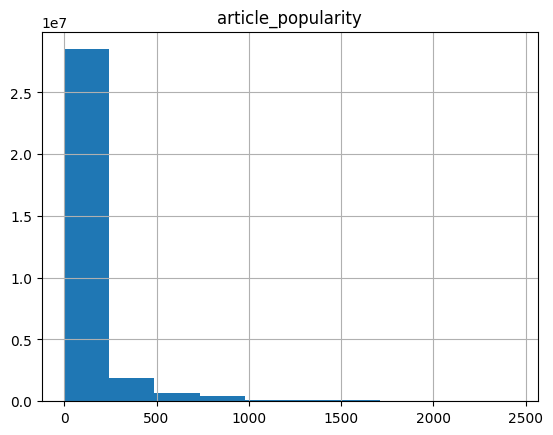

In [23]:
# distribution of article_popularity
transactions_processed[(transactions_processed.ordered == 1)].hist(column='article_popularity')

The distribution of `article_popularity` values looks exponential, so we perform a log transformation to normalize it.

array([[<AxesSubplot: title={'center': 'article_popularity'}>]],
      dtype=object)

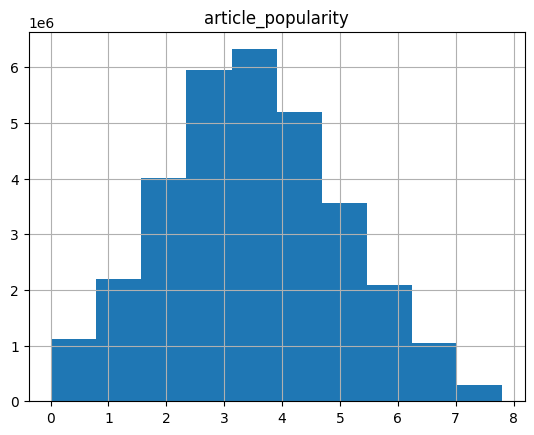

In [24]:
# log transform article_popularity
transactions_processed['article_popularity'] = np.log(transactions_processed['article_popularity'] + 1)
transactions_processed[(transactions_processed.ordered == 1)].hist(column='article_popularity')

In [25]:
# Preprocessing
# one-hot encoding of member_status, sales_channel_id and product_group_name
transactions_processed = pd.get_dummies(transactions_processed, columns=['member_status', 'sales_channel_id', 'product_group_name'])

# scaling numerical features to mean=0, std=1
column_names = transactions_processed.columns.tolist()
column_names.remove('ordered')

scaler = preprocessing.StandardScaler()
transactions_processed[column_names] = scaler.fit_transform(transactions_processed[column_names])
transactions_processed.head()

,article_popularity,price,age,ordered,member_status_Active_FN,member_status_NotActive_FN,member_status_NotActive_NoFN,sales_channel_id_1,sales_channel_id_2,product_group_name_Accessories,...,product_group_name_Interior textile,product_group_name_Items,product_group_name_Nightwear,product_group_name_Shoes,product_group_name_Socks & Tights,product_group_name_Stationery,product_group_name_Swimwear,product_group_name_Underwear,product_group_name_Underwear/nightwear,product_group_name_Unknown
0,-0.247728,0.845899,-0.853212,1,-0.782092,-0.088386,0.79502,-0.812925,0.812925,-0.29069,...,-0.003862,-0.012548,-0.121196,-0.195264,-0.151317,-0.005182,-0.242479,3.748547,-0.016235,-0.045523
1,-0.247728,0.845899,-0.853212,1,-0.782092,-0.088386,0.79502,-0.812925,0.812925,-0.29069,...,-0.003862,-0.012548,-0.121196,-0.195264,-0.151317,-0.005182,-0.242479,3.748547,-0.016235,-0.045523
2,-0.247728,0.845899,1.293020,0,-0.782092,-0.088386,0.79502,-0.812925,0.812925,-0.29069,...,-0.003862,-0.012548,-0.121196,-0.195264,-0.151317,-0.005182,-0.242479,3.748547,-0.016235,-0.045523
3,-0.247728,0.845899,-0.781671,1,-0.782092,-0.088386,0.79502,-0.812925,0.812925,-0.29069,...,-0.003862,-0.012548,-0.121196,-0.195264,-0.151317,-0.005182,-0.242479,3.748547,-0.016235,-0.045523
4,-0.247728,0.845899,-0.781671,1,-0.782092,-0.088386,0.79502,-0.812925,0.812925,-0.29069,...,-0.003862,-0.012548,-0.121196,-0.195264,-0.151317,-0.005182,-0.242479,3.748547,-0.016235,-0.045523


### Training, Testing and Scoring

In [26]:
# Creating a Train / Test Split:
X_train, X_test, y_train, y_test = train_test_split(
    transactions_processed.drop('ordered', axis=1), 
    transactions_processed['ordered'], 
    test_size=0.10, 
    random_state=42
)

In [27]:
# train the model
baseline = LogisticRegression(random_state=42)
baseline = baseline.fit(X_train, y_train)

In [28]:
# Mean Accuracy:
print(f'Mean Accuracy: {baseline.score(X_test, y_test):.2%}')

Mean Accuracy: 77.87%


In [29]:
# Classification Metrics:
predictions = baseline.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78   3178730
           1       0.78      0.77      0.78   3178935

    accuracy                           0.78   6357665
   macro avg       0.78      0.78      0.78   6357665
weighted avg       0.78      0.78      0.78   6357665

